In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

#set up display
is_ipython='inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [3]:
#Deep Q network
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1=nn.Linear(in_features=img_height*img_width*3, out_features=24) #change *3 later
        self.fc2=nn.Linear(in_features=24, out_features=32)
        self.out=nn.Linear(in_features=32, out_features=2)
    
    def forward(self, t):
        t=t.flatten(start_dim1)
        t=F.relu(self.fc1(t))
        t=F.relu(self.fc2(t))
        t=self.out(t)
        return t

In [4]:
Experience = namedtuple('Experience',
                        ('state','action','next_state','reward'))

In [5]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.push_count=0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity]=experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
        
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size
   
        

In [6]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step): 
        ER = self.end + (self.start - self.end)*math.exp(-1*current_step*self.decay)
        return ER
    

In [7]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self. num_actions = num_actions
        self.device=device
        
    def select_action(self, state, policy_net):
        rate= strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) #exploit
    


In [12]:
class CartPoleEnvManager():
    def __init__(self, storage):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.Done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        new_state, reward, self.done, info = self.env.step(action.item())
        return torch.tensor([reward], device = self.device)
    
    def just_starting(self):
        self.current_screen is None
        
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return self.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return self.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self,screen):
        screen_height = screen.shape[1]
        
        top = int(screen_height * .4)
        bottom = int(screen_height * .8)
        screen = screen[:,top:bottom,:]
        return screen
    
    def transform_screen_data(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device)
    

Example of Non-processed screen

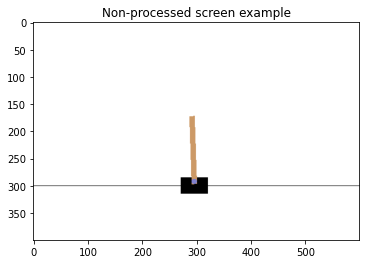

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

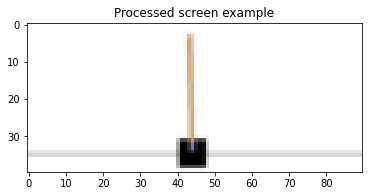

In [14]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = 'none')
plt.title('Processed screen example')
plt.show()

**===================Break===================**


In [ ]:
env=gym.make('CartPole-v0')
env.reset()
print('Observation Space', env.observation_space)
print('Action space', env.action_space)

In [ ]:
class Agent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self,state):
        theta = state[2]
        if theta>0: action=1
        else: action=0
        #action = random.choice(range(self.action_size))
        
        return action


In [ ]:
agent = Agent(env)
state = env.reset()

for _ in range(200):
    action = agent.get_action(state)
    state, reward, done, info = env.step(action)
    env.render()
    
    if done: break
    
input()
env.close()

In [ ]:
env.reset()
env.render()
for i in range(200):
    obs, reward, done, info = env.step(1)
    if done: env.reset()
    env.render()
input()
env.close()


In [22]:
em.close()

OK, now for Deep Learning